In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

/home/troch/venvs/misc-python-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('ggplot')

In [3]:
%load_ext autoreload
%autoreload 2

### Question e)

In [4]:
c, data, G, idx, coords, xi, yi = get_spatial_data()

In [5]:
l = 1
N = data.shape[0]
K = GaussianKernel(coords, l)
Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
u0 = Kc @ np.random.randn(N,)

In [6]:
n = 10000
beta = 0.2
thin = 500

pcn_pois_samps = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=c, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)[0]

pCN iterations:


100%|██████████| 10000/10000 [00:02<00:00, 4584.93it/s]


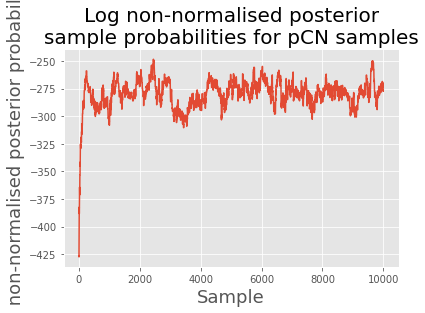

In [15]:
Kc_inv = np.linalg.inv(Kc)
K_inv = Kc_inv.T @ Kc_inv
pcn_samp_lpps = np.array([log_poisson_target(u, c, K_inv, G) for u in pcn_pois_samps])

plt.plot(pcn_samp_lpps)
plt.title("Log non-normalised posterior\nsample probabilities for pCN samples", fontsize=20)
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Log non-normalised posterior probability', fontsize=18)
plt.show()

In [16]:
r = 1001
a = np.zeros((N, r))
for i in tqdm(range(N)):
    for j in range(r):
        pcn_pois_samps[:,i]
        a[i,j] = pd.Series.autocorr(pd.Series(pcn_pois_samps[:,i]), lag=j)

100%|██████████| 207/207 [01:24<00:00,  2.44it/s]


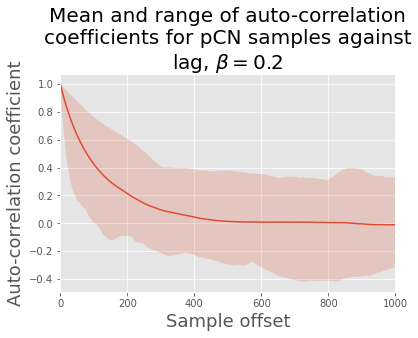

In [19]:
plt.plot(np.arange(r), a.mean(axis=0))
plt.fill_between(np.arange(r), a.max(axis=0), a.min(axis=0), alpha=0.2)
plt.title(r'Mean and range of auto-correlation'+'\ncoefficients for pCN samples against\nlag,'+r' $\beta=0.2$', fontsize=20)
plt.ylabel('Auto-correlation coefficient', fontsize=18)
plt.xlabel('Sample offset', fontsize=18)
plt.xlim(0, r-1)
plt.show()

In [7]:
n = 500000
beta = 0.2
thin = 600

pcn_pois_samps = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=c, K=Kc@Kc.T, G=G, n_iters=n, beta=beta)[0]
ind_samps = pcn_pois_samps[::thin]

pCN iterations:


100%|██████████| 500000/500000 [01:12<00:00, 6862.11it/s] 


### Question f)

In [47]:
mean_preds = np.exp(ind_samps).mean(axis=0)

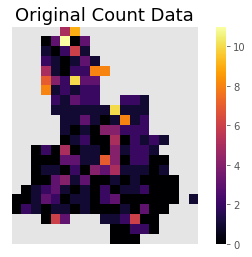

In [8]:
plot_2D(data, xi, yi, title='Original Count Data')

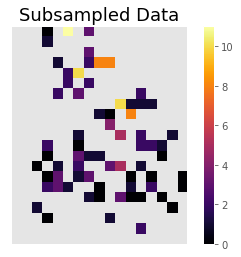

In [9]:
plot_2D(c, xi[idx], yi[idx], lim=np.max(data), title='Subsampled Data')

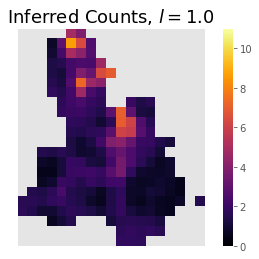

In [49]:
plot_2D(mean_preds, xi, yi, lim=np.max(data), title='Inferred Counts, $l=1.0$')

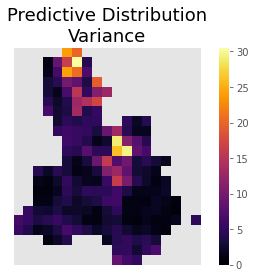

In [57]:
plot_2D(var, xi, yi, lim=None, title='Predictive Distribution\nVariance')

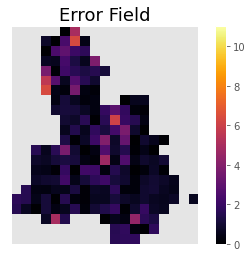

In [74]:
plot_2D(np.abs(mean_preds-data), xi, yi, lim=np.max(data), title='Error Field')

In [8]:
l_h = 20
l_l = 0.001
K_h = GaussianKernel(coords, l_h)
K_l = GaussianKernel(coords, l_l)

ind_samps_h = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=c, K=K_h, G=G, n_iters=500000, beta=beta)[0][::thin]
ind_samps_l = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=c, K=K_l, G=G, n_iters=500000, beta=beta)[0][::thin]

pCN iterations:


100%|██████████| 500000/500000 [01:27<00:00, 5722.63it/s]


pCN iterations:


100%|██████████| 500000/500000 [02:13<00:00, 3759.30it/s]


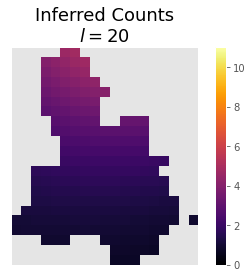

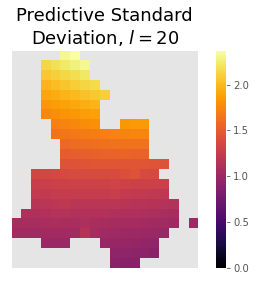

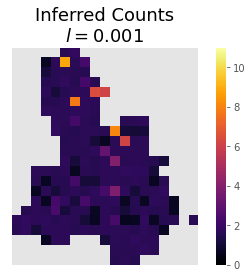

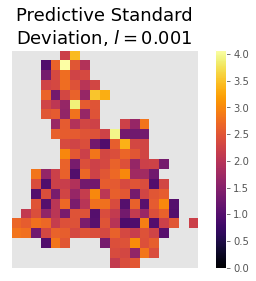

In [9]:
mean_preds_h = np.exp(ind_samps_h).mean(axis=0)
pred_var_h = pred_dist_var(ind_samps_h)
mean_preds_l = np.exp(ind_samps_l).mean(axis=0)
pred_var_l = pred_dist_var(ind_samps_l)
plot_2D(mean_preds_h, xi, yi, lim=np.max(data), title='Inferred Counts\n'+r'$l = 20$')
plot_2D(np.sqrt(pred_var_h), xi, yi, lim=None, title='Predictive Standard\n'+r'Deviation, $l = 20$')
plot_2D(mean_preds_l, xi, yi, lim=np.max(data), title='Inferred Counts\n'+r'$l = 0.001$')
plot_2D(np.sqrt(pred_var_l), xi, yi, lim=None, title='Predictive Standard\n'+r'Deviation, $l = 0.001$')

In [25]:
grains = 500
ls = np.logspace(-1, 2, grains)
lmls = []

for l in tqdm(ls):
    lmls.append(est_log_evidence(l, G, c, log_poisson_likelihood, n_samps=100000, coords=coords))
    
lmls = np.array(lmls)

100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


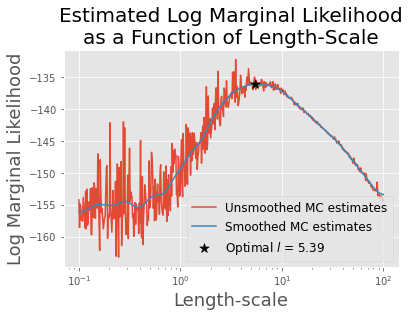

In [30]:
smoothed_lmls = gaussian_filter1d(lmls, 10)
opt_l_ind = np.argmax(smoothed_lmls)
opt_ml = smoothed_lmls[opt_l_ind]
plt.plot(ls, lmls, label='Unsmoothed MC estimates')
plt.plot(ls, smoothed_lmls, label='Smoothed MC estimates')
# plt.axvline(x=0.25, linestyle='--', label=r'True $l = 0.25$', color='C5')
plt.scatter(ls[opt_l_ind], opt_ml, label=r'Optimal $l$'+f' = {round(ls[opt_l_ind], 2)}', color='black', zorder=5, marker='*', s=100)
plt.xscale('log')
plt.title('Estimated Log Marginal Likelihood\nas a Function of Length-Scale', fontsize=20)
plt.xlabel('Length-scale', fontsize=18)
plt.ylabel('Log Marginal Likelihood', fontsize=18)
plt.legend(fontsize=12)

plt.show()

In [27]:
l_opt = 5.39
K_opt = GaussianKernel(coords, l_opt)

ind_samps_opt = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=c, K=K_opt, G=G, n_iters=500000, beta=beta)[0][::thin]

pCN iterations:


100%|██████████| 500000/500000 [01:20<00:00, 6177.03it/s]


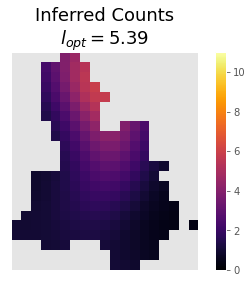

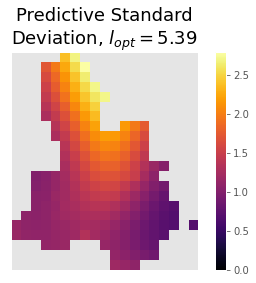

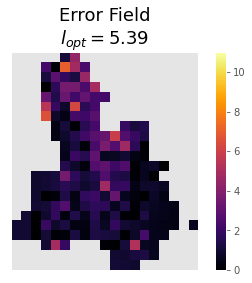

In [28]:
mean_preds_opt = np.exp(ind_samps_opt).mean(axis=0)
pred_var_opt = pred_dist_var(ind_samps_opt)

plot_2D(mean_preds_opt, xi, yi, lim=np.max(data), title='Inferred Counts\n'+r'$l_{opt} = 5.39$')
plot_2D(np.sqrt(pred_var_opt), xi, yi, lim=None, title='Predictive Standard\n'+r'Deviation, $l_{opt} = 5.39$')
plot_2D(np.abs(mean_preds_opt-data), xi, yi, lim=np.max(data), title='Error Field\n'+r'$l_{opt} = 5.39$')

In [13]:
cs, data, Gs, idxs, coords, xi, yi = get_spatial_data(validate=True)
tr_c, val_c, c = cs
tr_G, val_G, G = Gs
tr_idx, val_idx, idx = idxs

In [14]:
grains = 500
ls = np.logspace(-1, 2, grains)
Ks = np.array([GaussianKernel(coords, l) for l in ls])

data_errors = []
for K in tqdm(Ks):
    ind_samps = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=tr_c, K=K, G=tr_G, n_iters=10000, beta=beta, silence=True)[0][::thin]
    preds = np.exp(ind_samps).mean(axis=0)
    data_errors.append(mean_pred_error(val_G@preds, val_c))

100%|██████████| 500/500 [15:05<00:00,  1.81s/it]


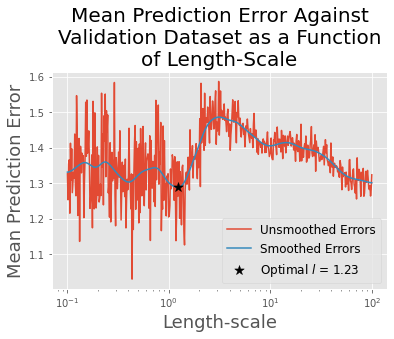

In [31]:
smoothed_de = gaussian_filter1d(data_errors, 10)
plt.plot(ls, data_errors, label='Unsmoothed Errors')
plt.plot(ls, smoothed_de, label='Smoothed Errors')
d_opt_l_ind = np.argmin(smoothed_de)
opt_de = smoothed_de[d_opt_l_ind]
plt.scatter(ls[d_opt_l_ind], opt_de, label=r'Optimal $l$'+f' = {round(ls[d_opt_l_ind], 2)}', color='black', zorder=5, marker='*', s=100)
plt.xscale('log')
plt.title('Mean Prediction Error Against\nValidation Dataset as a Function\nof Length-Scale', fontsize=20)
plt.xlabel('Length-scale', fontsize=18)
plt.ylabel('Mean Prediction Error', fontsize=18)
plt.legend(fontsize=12)

plt.show()

In [17]:
l_opt2 = 1.2251
K_opt2 = GaussianKernel(coords, l_opt2)

ind_samps_opt2 = pcn(log_likelihood=log_poisson_likelihood, u0=u0, data=tr_c, K=K_opt2, G=tr_G, n_iters=n, beta=beta)[0][::thin]

pCN iterations:


100%|██████████| 10000/10000 [00:00<00:00, 11140.42it/s]


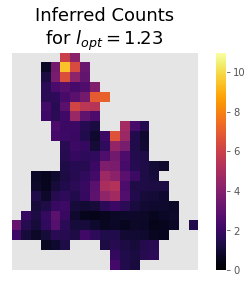

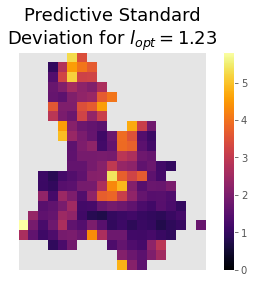

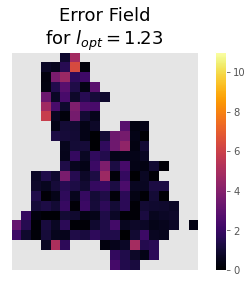

In [24]:
mean_preds_opt2 = np.exp(ind_samps_opt2).mean(axis=0)
pred_var_opt2 = pred_dist_var(ind_samps_opt2)
plot_2D(mean_preds_opt2, xi, yi, lim=np.max(data), title='Inferred Counts\n'+r'$l_{opt} = 1.23$')
plot_2D(np.sqrt(pred_var_opt2), xi, yi, lim=None, title='Predictive Standard\n'+r'Deviation, $l_{opt} = 1.23$')
plot_2D(np.abs(mean_preds_opt2-data), xi, yi, lim=np.max(data), title='Error Field\n'+r'$l_{opt} = 1.23$')
